In [1]:
%pip install plotly
%pip install sklearn
%pip install scikit-learn
%pip install matplotlib
%pip install seaborn
%pip install pandas
%pip install wordcloud

  Obtaining dependency information for plotly from https://files.pythonhosted.org/packages/e5/ae/580600f441f6fc05218bd6c9d5794f4aef072a7d9093b291f1c50a9db8bc/plotly-5.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for tenacity>=6.2.0 from https://files.pythonhosted.org/packages/b6/cb/b86984bed139586d01532a587464b5805f12e397594f19f931c4c2fbfa61/tenacity-9.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/19.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/19.1 MB 1.3 MB/s eta 0:00:15
    --------------------------------------- 0.4/19.1 MB 6.0 MB/s eta 0:00:04
   ---- ----------------------------------- 2.0/19.1 MB 18.3 MB/s eta 0:00:01
   -------- ------------------------------- 4.0/19.1 MB 25.6 MB/s eta 0:00:01
   -------------- ------------------------- 7.1/19.1 MB 34.9 MB/s eta 0:00:01
   ------------------- -------------------- 9.1/19.1 MB 36.2 MB/s eta 0:00:01
   ---------------------- ----------------- 10.8/19.1 MB 4


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates from a subpr


  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/96/a2/cbfb5743de748d574ffdfd557e9cb29ba4f8b8a3e07836c6c176f713de2f/scikit_learn-1.6.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for numpy>=1.19.5 from https://files.pythonhosted.org/packages/d0/06/3d1ff6ed377cb0340baf90487a35f15f9dc1db8e0a07de2bf2c54a8e490f/numpy-2.2.0-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/ea/c2/5ecadc5fcccefaece775feadcd795060adf5c3b29a883bff0e678cfe89af/scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 60.8/60


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/14/cf/e382598f98be11bf51dd0bc60eca44a517f6793e3dc8b9d53634a144620c/matplotlib-3.10.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/a8/7e/cd93cab453720a5d6cb75588cc17dcdc08fc3484b9de98b885924ff61900/contourpy-1.3.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/be/36/d74ae1020bc41a1dff3e6f5a99f646563beecb97e386d27abdac3ba07650/fonttools-4.55.3-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/168.5 kB ? eta -:--:--
     -------------- ------------------------ 61.4/168.5 kB 1.6 MB/s 


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=1.2 from https://files.pythonhosted.org/packages/ed/8c/87ddf1fcb55d11f9f847e3c69bb1c6f8e46e2f40ab1a2d2abadb2401b007/pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata
  Using cached pandas-2.2.3-cp311-cp311-win_amd64.whl.metadata (19 kB)
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/11/c3/005fcca25ce078d2cc29fd559379817424e94885510568bc1bc53d7d5846/pytz-2024.2-py2.py3-none-any.whl.metadata
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/a6/ab/7e5f53c3b9d14972843a647d8d7a853969a58aecc7559cb3267302c94774/tzdata-2024.2-py2.py3-none-any.whl.metadata
  Using cached tzdata-2024.2-py2.py3-


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for wordcloud from https://files.pythonhosted.org/packages/00/09/abb305dce85911b8fba382926cfc57f2f257729e25937fdcc63f3a1a67f9/wordcloud-1.9.4-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/299.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/299.9 kB ? eta -:--:--
   ----- --------------------------------- 41.0/299.9 kB 393.8 kB/s eta 0:00:01
   ---------------------------------------  297.0/299.9 kB 2.3 MB/s eta 0:00:01
   ---------------------------------------- 299.9/299.9 kB 2.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import json
import pandas as pd
from main import count_occurrences, establish_unk_words
from wordcloud import WordCloud

# OUT-OF-DOMAIN RESULTS

In [3]:
counts_trains = count_occurrences('UD-Data/out_of_domain/', ['train'], write=False)
counts_dev = count_occurrences('UD-Data/out_of_domain/', ['dev'], write=False)
counts_test = count_occurrences('UD-Data/out_of_domain/', ['test'], write=False)
total_counts = count_occurrences('UD-Data/out_of_domain/', ['train', 'dev', 'test'], write=False)

6711
3675
5508
6711
3675
5508


## ENGLISH


### DATASET ANALYSIS

The Out of Domain English dataset we have chosen is the "Tweebsnk v2" avaliable in this [github](https://github.com/Oneplus/Tweebank/tree/dev). This is a collection of English tweets annotated with POS tags, following the Universal Dependencies. The dataset is already divided in train, dev and test sets. 

In [4]:
dataset_path = "UD-Data/out_of_domain/English/"
def conllu_dict(file_path, i=0):
    with open(file_path, "r", encoding="utf-8") as f:
        tags = []
        sentence = []
        info = {}
        for line in f:
            if line == '\n' and len(tags)!=0:                     
                info[i] = {"tags": tags, "sentence": sentence}
                i+=1
                tags, sentence = [], []
            elif line[0] == '#': pass
            else:
                w_id, word, lemma, tag, _, _, _, tag2, _, _ = line.split('\t')
                sentence.append(word.lower())
                tags.append(tag)
    return info, i

info_train, i = conllu_dict(f'{dataset_path}/en-ud-tweet-train.conllu') 
info_dev, i = conllu_dict(f'{dataset_path}/en-ud-tweet-dev.conllu', i+1) 
info_test, i = conllu_dict(f'{dataset_path}/en-ud-tweet-test.conllu', i+1) 
all_info = {**info_train, **info_dev, **info_test}

Since the corpus could be used as a training dataset, they are divided in 3 files, but here we will analyze it as a single file. The initial division of the sentences and words was the following one:

* en-ud-tweet-train.conllu: 1,639 tweets (24,753 words)
* en-ud-tweet-dev.conllu: 710 tweets (11,742 words)
* en-ud-tweet-test.conllu: 1,201 tweets (19,112 words)

In total there are 3550 sentences or 55607 tagged words. 

In [5]:
train_words = 0
dev_words = 0
test_words = 0
train_lengths = []
dev_lengths = []
test_lengths = []

for doc in info_train.values():
    if isinstance(doc, dict):
        train_lengths.append(len(doc['sentence']))
        train_words += len(doc['sentence'])
for doc in info_dev.values():
    if isinstance(doc, dict):
        dev_lengths.append(len(doc['sentence']))
        dev_words += len(doc['sentence'])
for doc in info_test.values():
    if isinstance(doc, dict):
        test_lengths.append(len(doc['sentence']))
        test_words += len(doc['sentence'])

print("Number of sentences:", len(info_train)+len(info_dev)+len(info_test)-3)
print("Number of words:", test_words + dev_words + train_words)

Number of sentences: 3547
Number of words: 55607


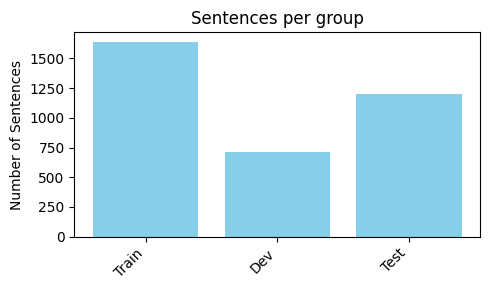

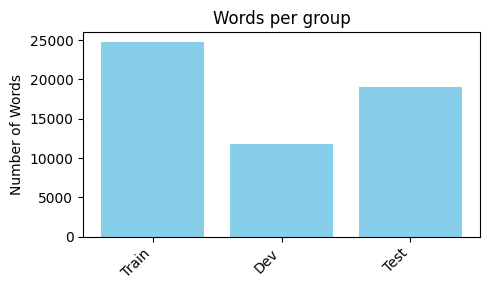

In [6]:
def counts_for_files(files, sentences, counting='Sentences'):    
    plt.figure(figsize=(5, 3))
    plt.bar(files, sentences, color='skyblue')
    plt.ylabel(f'Number of {counting}')
    plt.title(f'{counting} per group')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


counts_for_files(['Train', 'Dev', 'Test'], [len(info_train)-1, len(info_dev)-1, len(info_test)-1])    
counts_for_files(['Train', 'Dev', 'Test'], [train_words, dev_words, test_words], "Words")  

As espected, since it is a Tweeter corpus, the sentence lenght variate from 1 to 40 words, being the mean 15 characters. This can be seen in the boxplots bellow: 

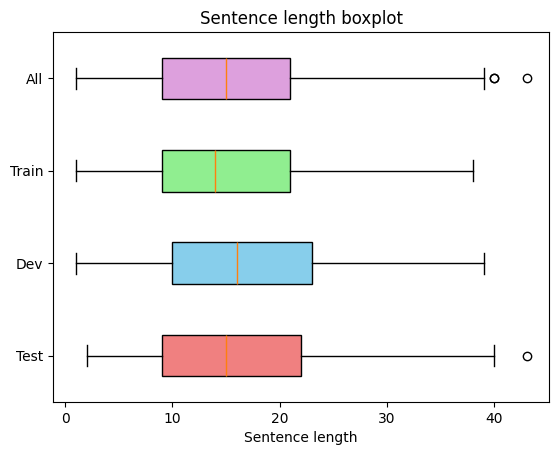

In [7]:
def sentence_length_boxplot(docs, lengths):
    fig, ax = plt.subplots()
    box = ax.boxplot(lengths, vert=False, patch_artist=True)
    colors = ['lightcoral', 'skyblue', 'lightgreen', 'plum']
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    ax.set_yticklabels(docs)
    ax.set_xlabel('Sentence length')
    ax.set_title('Sentence length boxplot')
    plt.show()

sentence_length_boxplot(['Test', 'Dev', 'Train', 'All'], [test_lengths, dev_lengths, train_lengths, train_lengths+dev_lengths+test_lengths])

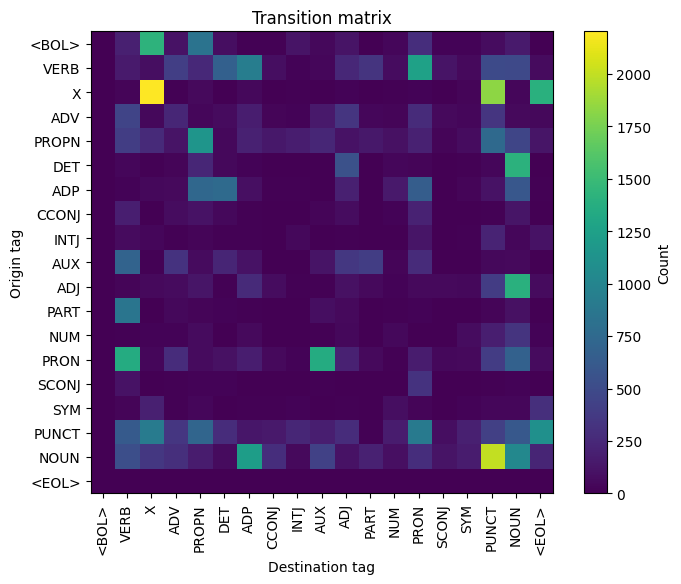

In [8]:
import plotly.express as px
import seaborn as sns
import numpy as np

transitions = total_counts['English']["transitions"]

def get_transition_matrix_and_labels(transitions):
    labels = set()
    for transition in transitions.keys():
        before, after = transition.split(", ")
        labels.add(before)
        labels.add(after)

    # Crear un índice para las etiquetas
    ordered_labels = ["<BOL>"] + [label for label in labels if label != "<BOL>" and label != "<EOL>"] + ["<EOL>"]
    labels = ordered_labels
    label_index = {label: i for i, label in enumerate(labels)}

    # Crear la matriz de transiciones (inicialmente llena de ceros)
    n = len(labels)
    matrix = np.zeros((n, n))

    # Rellenar la matriz con los datos de transiciones
    for transition, count in transitions.items():
        before, after = transition.split(", ")
        i = label_index[before]
        j = label_index[after]
        matrix[i, j] = count
    return matrix, labels

def transition_matrix(transitions):
    matrix, labels = get_transition_matrix_and_labels(transitions)

    plt.figure(figsize=(8, 6))
    cax = plt.imshow(matrix, cmap="viridis", interpolation="nearest")
    plt.colorbar(cax, label="Count")
    plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=90)
    plt.yticks(ticks=np.arange(len(labels)), labels=labels)
    plt.title("Transition matrix")
    plt.xlabel("Destination tag")
    plt.ylabel("Origin tag")

transition_matrix(transitions)


As expected, the predominant words in the dataset are those related to Twitter, such as "RT", abbreviated words like "u", "lmao", or "lol", and terminology related to entertainment ("video", "game", etc.); all of this in a more colloquial register than in other contexts. This type of terminology is more common in the social media context, not only because the number of characters is limited (as seen in the boxplot representing the length of phrases used in each tweet), but also because the topics of interest on social media are more varied, ranging from politics to entertainment, among others.

This differs from what was seen in the training set, where, being a dataset focused on the legal field, news, and Wikipedia, more elaborate and complex terminologies are used.

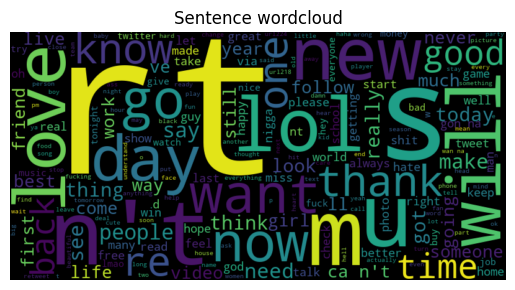

In [18]:
def wordclouds_by_tag(info):
    num_por_linea = 4
    plt.figure(figsize=(15, 10), facecolor='white') 
    
    for i, (categoria, palabras) in enumerate(info.items()):
        text = ' '.join(palabras)
        wordcloud = WordCloud(width=400, height=400, background_color=None, regexp=r'\S+').generate(text)
        
        plt.subplot(len(info) // num_por_linea + 1, num_por_linea, i + 1)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(categoria)
    plt.tight_layout()
    plt.show()


def wordcloud_of_words_or_sentences(sentences, title="Sentence wordcloud"):
    joined_sentences = ' '
    if all(isinstance(words, list) for words in sentences): # If it is an array of arrays with words [['I', 'am', 'a', 'sentence'], ['I', 'am', 'another', 'sentence']]
        sent_flat = [palabra for sublista in sentences for palabra in sublista]
        joined_sentences = ' '.join(sent_flat)
    elif all(isinstance(sentence, str) for sentence in sentences): # If it is an array of strings ['I am a sentence', 'I am another sentence']
        joined_sentences = ' '.join(sentences)
        
    wordcloud = WordCloud(width=800, height=400, background_color=None).generate(joined_sentences)
    plt.figure()
    plt.title(title)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()



all_sentences = []
for i in all_info.values():
    all_sentences += [' '.join(i['sentence'])]
wordcloud_of_words_or_sentences(all_sentences)

Here can be seen all the most common words for each PoS tag. Considering that PoS tags like NOUN or VERB have a fairly concrete definition of the types of words they cover (in this case, nouns and verbs respectively), in this case, we will focus on analyzing those tags that have more open definitions, subject to interpretation:

SYM: This tag is defined by having symbols. In the case of this dataset, all special characters not categorized under any other label have been considered symbols, as well as emoticons, special characters ($, %, @...) and others.
X: This category, left open for "others", has collected words that begin with "url", "http", and other types of Twitter-specific words such as "RT".


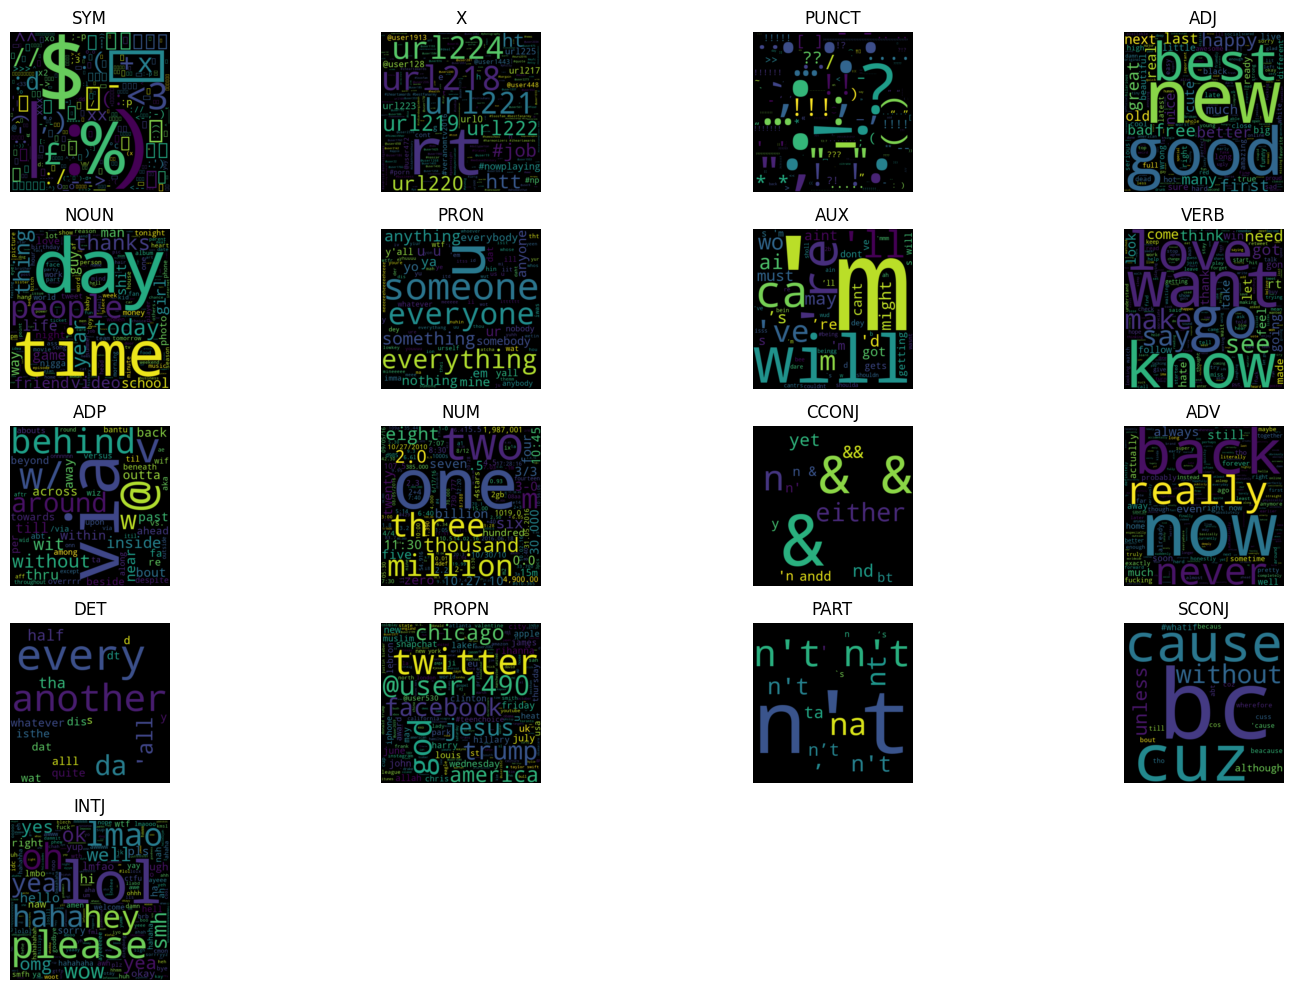

In [19]:
words_per_tag = {'SYM':[], 'X':[]}
for instance in all_info.values():
    for i, tag in enumerate(instance['tags']):
        if tag not in words_per_tag.keys():
            words_per_tag[tag] = []
        words_per_tag[tag] += [instance['sentence'][i]]
        
wordclouds_by_tag(words_per_tag)

### ERROR ANALYSIS

In [15]:
lang = "English"
ruta_archivo = f"output/od_{lang}_predictions.jsonl"

all_tags = []
all_predictions = []

# read de jsonl file and process it
with open(ruta_archivo, "r", encoding="utf-8") as archivo:
    contenido = archivo.read()
    contenido = "[" + contenido.strip().replace("}\n{", "},{") + "]"
    elementos = json.loads(contenido)
    #print(len(elementos[0]))

# get the tag and prediction of each instance and concatenate them
for elemento in elementos:
    all_tags.extend(elemento.get("tags", []))
    all_predictions.extend(elemento.get("prediction", []))

In [16]:
accuracy = accuracy_score(all_tags, all_predictions)
accuracy

0.6083000255123735

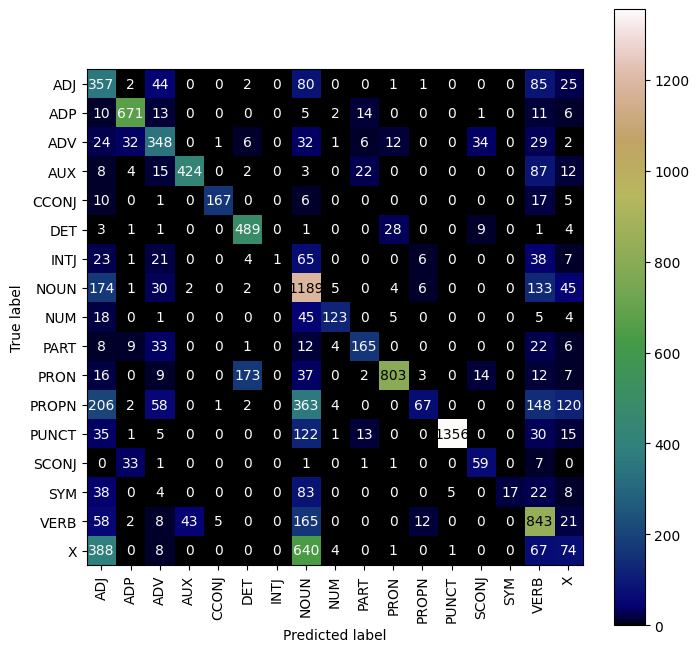

In [17]:
#create the confusion matrix
tags_set = sorted(set(all_tags))
cm = confusion_matrix(all_tags, all_predictions, labels=tags_set)
cm

#show the plot
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust width and height as needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_set)
disp.plot(cmap="gist_earth", ax=ax, xticks_rotation="vertical")

plt.show()